Load Dataset

In [9]:
from nilmtk import DataSet
import pandas as pd
import numpy as np
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Use data in  house 1,2 and 5 only
house_indicies = [1, 2, 5]

# Load UK-DALE .h5 dataset
ukdale = DataSet(r'C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5')

#Hyperparameters
sample_period = 6;
noise_threshold = 5; #Noise threshold in Watts



In [10]:

# ---------------------------------------------------------------------------------------------------
#                                        Main Meter data capturing
#
# ---------------------------------------------------------------------------------------------------

# Store all processed data separately for each appliance
all_house_mains_data = []
all_house_kettle_data = []
all_house_microwave_data = []
all_house_fridge_data = []
all_house_dishwasher_data = []
all_house_washing_machine_data = []

# Standardized appliance names (final output)
appliance_name2 = ['kettle', 'microwave', 'fridge', 'dishwasher', 'washing_machine']

# Mapping from original names to standardized names
appliance_mapping = {
    'fridge freezer': 'fridge',
    'fridge': 'fridge',
    'dish washer': 'dishwasher', 
    'dishwasher': 'dishwasher',
    'washer dryer': 'washing_machine',
    'washing machine': 'washing_machine',
    'washing_machine': 'washing_machine'
}

# Original appliance names per building (for loading)
appliance_name = [['kettle', 'microwave', 'fridge freezer', 'dish washer', 'washer dryer'],
                   ['kettle', 'microwave', 'fridge', 'dish washer', 'washing machine'],
                   ['kettle', 'microwave', 'fridge freezer', 'dish washer', 'washer dryer']]

#Load Power in the selectec houses
for idx, house_id in enumerate(house_indicies):
    print("************************************************")
    print(f"Loading power data for Building {house_id}")

    #Get electricity data for that house
    elec = ukdale.buildings[house_id].elec #elec is a MeterGroup object that represents all the meters in the building

    #Load mains(aggregated power)
    mains = elec.mains()
    df_mains = next(mains.load(sample_period=sample_period))

    #Rename the column name
    df_mains = df_mains['power']['active']
    df_mains = df_mains.to_frame(name='P_mains')


    # ---------------------------------------------------------------------------------------------------
    #  Data Quality Filtering for mains data
    # ---------------------------------------------------------------------------------------------------

    #Handling missing Value using forward fill (limit to 30 samples (180 seconds))
    df_mains = df_mains.resample(f"{sample_period}S").mean() ##Regularize timestamps
    df_mains = df_mains.fillna(method='ffill', limit=30) ## Fill short gaps (<= 30 samples) with the last valid observation

    #Delete the rest of NaN Values
    nan_count_before = df_mains.isnull().sum().sum()
    df_mains = df_mains.dropna().copy()
    nan_count_after = df_mains.isnull().sum().sum()
    nan_dropped = nan_count_before - nan_count_after
    print(f"  * NaN values in P_main dropped: {nan_dropped:,} (from {nan_count_before:,} to {nan_count_after:,})")

    #Delete negative power if exists
    negative_power_count_before = df_mains[df_mains["P_mains"] < 0].shape[0]
    df_mains = df_mains[df_mains["P_mains"] > 0]
    negative_power_count_after = df_mains[df_mains["P_mains"] < 0].shape[0]
    negative_power_dropped = negative_power_count_before - negative_power_count_after
    print(f"  * Negative power in P_mains values dropped: {negative_power_dropped:,} (from {negative_power_count_before:,} to {negative_power_count_after:,})")


    # ---------------------------------------------------------------------------------------------------
    #                                        Appliances data capturing
    #
    # ---------------------------------------------------------------------------------------------------

    for app in appliance_name[idx]:
        # Get standardized name
        std_app = appliance_mapping.get(app, app)
        
        # Only process if it's one of our target appliances
        if std_app in appliance_name2:
            #Check if appliance exists in the building
            appliance_found = False
            for appliances in elec.appliances:
                if appliances.identifier.type == app:
                    appliance_found = True
                    break

            if appliance_found:
                #Load appliance data
                df_app = next(elec[app].load(sample_period=sample_period))
                df_app = df_app['power']['active'].to_frame(name=std_app)
                
                # Data Quality Filtering
                df_app = df_app.resample(f"{sample_period}S").mean().fillna(method='ffill', limit=30)

                #Merge the appliances in mains data
                df_mains[std_app] = df_app[std_app]
                print(f"  - Loaded {app} -> {std_app} data")
        
    # Store mains data separately
    df_mains_only = df_mains[['P_mains']].copy()
    all_house_mains_data.append(df_mains_only)
    
    # Process each appliance separately with its own data
    for std_app in appliance_name2:
        if std_app in df_mains.columns:
            # Get the appliance data with its original timestamps
            app_data = df_mains[std_app].dropna()  # Remove NaN values to get actual data length
            
            if len(app_data) > 0:
                # Get mains data for the same time period as appliance
                mains_for_app = df_mains.loc[app_data.index, 'P_mains']
                
                # Create combined dataframe with actual data lengths
                df_app_combined = pd.DataFrame({
                    'P_mains': mains_for_app,
                    std_app: app_data
                })
                
                # Store in appropriate list
                if std_app == 'kettle':
                    all_house_kettle_data.append(df_app_combined)
                elif std_app == 'microwave':
                    all_house_microwave_data.append(df_app_combined)
                elif std_app == 'fridge':
                    all_house_fridge_data.append(df_app_combined)
                elif std_app == 'dishwasher':
                    all_house_dishwasher_data.append(df_app_combined)
                elif std_app == 'washing_machine':
                    all_house_washing_machine_data.append(df_app_combined)
                
                print(f"  - {std_app}: {len(df_app_combined)} samples")
            else:
                print(f"  - {std_app}: No valid data found")
    
    print(f"Building {house_id} processed successfully")
    print(f"  Mains data shape: {df_mains_only.shape}")
    print(f"  Available appliances: {[app for app in appliance_name2 if app in df_mains.columns]}")
            


# Concatenate all data separately
if all_house_mains_data:
    entire_data_mains = pd.concat(all_house_mains_data, ignore_index=True)
    print(f"Mains data: {entire_data_mains.shape}")

if all_house_kettle_data:
    entire_data_kettle = pd.concat(all_house_kettle_data, ignore_index=True)
    print(f"Kettle data: {entire_data_kettle.shape}")

if all_house_microwave_data:
    entire_data_microwave = pd.concat(all_house_microwave_data, ignore_index=True)
    print(f"Microwave data: {entire_data_microwave.shape}")

if all_house_fridge_data:
    entire_data_fridge = pd.concat(all_house_fridge_data, ignore_index=True)
    print(f"Fridge data: {entire_data_fridge.shape}")

if all_house_dishwasher_data:
    entire_data_dishwasher = pd.concat(all_house_dishwasher_data, ignore_index=True)
    print(f"Dishwasher data: {entire_data_dishwasher.shape}")

if all_house_washing_machine_data:
    entire_data_washing_machine = pd.concat(all_house_washing_machine_data, ignore_index=True)
    print(f"Washing machine data: {entire_data_washing_machine.shape}")

print("\n✅ All appliance data saved separately!")



************************************************
Loading power data for Building 1
  * NaN values in P_main dropped: 38,692 (from 38,692 to 0)
  * Negative power in P_mains values dropped: 0 (from 0 to 0)
  - Loaded kettle -> kettle data
  - Loaded microwave -> microwave data
  - Loaded fridge freezer -> fridge data
  - Loaded dish washer -> dishwasher data
  - Loaded washer dryer -> washing_machine data
  - kettle: 9361653 samples
  - microwave: 9439225 samples
  - fridge: 9437230 samples
  - dishwasher: 9438190 samples
  - washing_machine: 9314733 samples
Building 1 processed successfully
  Mains data shape: (9443254, 1)
  Available appliances: ['kettle', 'microwave', 'fridge', 'dishwasher', 'washing_machine']
************************************************
Loading power data for Building 2
  * NaN values in P_main dropped: 512,548 (from 512,548 to 0)
  * Negative power in P_mains values dropped: 0 (from 0 to 0)
  - Loaded kettle -> kettle data
  - Loaded microwave -> microwave data

In [ ]:
# NEW APPROACH: First capture all raw data, then process
print("="*60)
print("STEP 1: CAPTURING ALL RAW DATA")
print("="*60)

# Store all processed data separately for each appliance
all_house_mains_data = []
all_house_kettle_data = []
all_house_microwave_data = []
all_house_fridge_data = []
all_house_dishwasher_data = []
all_house_washing_machine_data = []

# Standardized appliance names (final output)
appliance_name2 = ['kettle', 'microwave', 'fridge', 'dishwasher', 'washing_machine']

# Mapping from original names to standardized names
appliance_mapping = {
    'fridge freezer': 'fridge',
    'fridge': 'fridge',
    'dish washer': 'dishwasher', 
    'dishwasher': 'dishwasher',
    'washer dryer': 'washing_machine',
    'washing machine': 'washing_machine',
    'washing_machine': 'washing_machine'
}

# Original appliance names per building (for loading)
appliance_name = [['kettle', 'microwave', 'fridge freezer', 'dish washer', 'washer dryer'],
                   ['kettle', 'microwave', 'fridge', 'dish washer', 'washing machine'],
                   ['kettle', 'microwave', 'fridge freezer', 'dish washer', 'washer dryer']]

#Load Power in the selected houses
for idx, house_id in enumerate(house_indicies):
    print("************************************************")
    print(f"Loading RAW data for Building {house_id}")

    #Get electricity data for that house
    elec = ukdale.buildings[house_id].elec

    #Load mains(aggregated power) - RAW DATA
    mains = elec.mains()
    df_mains_raw = next(mains.load(sample_period=sample_period))
    df_mains_raw = df_mains_raw['power']['active'].to_frame(name='P_mains')
    raw_mains_data.append(df_mains_raw)
    print(f"Raw mains data: {len(df_mains_raw)} samples")

    #Load each appliance - RAW DATA
    for app in appliance_name[idx]:
        std_app = appliance_mapping.get(app, app)
        
        if std_app in appliance_name2:
            #Check if appliance exists in the building
            appliance_found = False
            for appliances in elec.appliances:
                if appliances.identifier.type == app:
                    appliance_found = True
                    break

            if appliance_found:
                #Load appliance data - RAW
                df_app_raw = next(elec[app].load(sample_period=sample_period))
                df_app_raw = df_app_raw['power']['active'].to_frame(name=std_app)
                
                # Store raw data
                if std_app == 'kettle':
                    raw_kettle_data.append(df_app_raw)
                elif std_app == 'microwave':
                    raw_microwave_data.append(df_app_raw)
                elif std_app == 'fridge':
                    raw_fridge_data.append(df_app_raw)
                elif std_app == 'dishwasher':
                    raw_dishwasher_data.append(df_app_raw)
                elif std_app == 'washing_machine':
                    raw_washing_machine_data.append(df_app_raw)
                
                print(f"Raw {app} -> {std_app} data: {len(df_app_raw)} samples")
            else:
                print(f"  ❌ {app} -> {std_app} not found")



print("\n" + "="*60)
print("STEP 2: PROCESSING AND RESAMPLING")
print("="*60)

# Now process each building's data with resampling
for idx, house_id in enumerate(house_indicies):
    print(f"\nProcessing Building {house_id}...")
    
    # Get raw data for this building
    df_mains_raw = raw_mains_data[idx]
    
    # Process each appliance separately - resample mains with each appliance
    for std_app in appliance_name2:
        app_data_list = []
        if std_app == 'kettle' and idx < len(raw_kettle_data):
            app_data_list = raw_kettle_data
        elif std_app == 'microwave' and idx < len(raw_microwave_data):
            app_data_list = raw_microwave_data
        elif std_app == 'fridge' and idx < len(raw_fridge_data):
            app_data_list = raw_fridge_data
        elif std_app == 'dishwasher' and idx < len(raw_dishwasher_data):
            app_data_list = raw_dishwasher_data
        elif std_app == 'washing_machine' and idx < len(raw_washing_machine_data):
            app_data_list = raw_washing_machine_data
        
        if app_data_list and idx < len(app_data_list):
            df_app_raw = app_data_list[idx]
            
            # Find common time range between mains and this appliance
            mains_start = df_mains_raw.index.min()
            mains_end = df_mains_raw.index.max()
            app_start = df_app_raw.index.min()
            app_end = df_app_raw.index.max()
            
            # Get overlapping time range
            start_time = max(mains_start, app_start)
            end_time = min(mains_end, app_end)
            
            if start_time < end_time:
                # Resample mains for this appliance's time range
                mains_for_app = df_mains_raw.loc[start_time:end_time]['P_mains'].resample(f'{sample_period}S').mean().ffill(limit=30)
                mains_for_app = mains_for_app.dropna()
                mains_for_app = mains_for_app[mains_for_app > 0]  # Remove negative values
                mains_for_app[mains_for_app < noise_threshold] = 0  # Set noise to 0
                
                # Resample appliance for the same time range
                app_for_mains = df_app_raw.loc[start_time:end_time][std_app].resample(f'{sample_period}S').mean().ffill(limit=30)
                app_for_mains = app_for_mains.dropna()
                
                # Align to common timeline
                common_times = mains_for_app.index.intersection(app_for_mains.index)
                if len(common_times) > 0:
                    mains_aligned = mains_for_app.loc[common_times]
                    app_aligned = app_for_mains.loc[common_times]
                    
                    # Build combined array: time index + mains + appliance
                    combined = pd.DataFrame({
                        'P_mains': mains_aligned,
                        std_app: app_aligned
                    }, index=common_times)  # time is the index
                    
                    # Store in appropriate list
                    if std_app == 'kettle':
                        all_house_kettle_data.append(combined)
                    elif std_app == 'microwave':
                        all_house_microwave_data.append(combined)
                    elif std_app == 'fridge':
                        all_house_fridge_data.append(combined)
                    elif std_app == 'dishwasher':
                        all_house_dishwasher_data.append(combined)
                    elif std_app == 'washing_machine':
                        all_house_washing_machine_data.append(combined)
                    
                    print(f"  📊 Processed {std_app}: {len(combined)} samples")
                else:
                    print(f"  ❌ No common time range for {std_app}")
            else:
                print(f"  ❌ No overlapping time range for {std_app}")
        else:
            print(f"  ❌ No data for {std_app}")
    
    # Store mains data (full timeline)
    mains_full = df_mains_raw['P_mains'].resample(f'{sample_period}S').mean().ffill(limit=30)
    mains_full = mains_full.dropna()
    mains_full = mains_full[mains_full > 0]
    mains_full[mains_full < noise_threshold] = 0
    all_house_mains_data.append(mains_full.to_frame('P_mains'))

print("\n" + "="*60)
print("STEP 3: CONCATENATE ALL DATA")
print("="*60)

# Concatenate all data separately
if all_house_mains_data:
    entire_data_mains = pd.concat(all_house_mains_data, ignore_index=True)
    print(f"✅ Mains data: {entire_data_mains.shape}")

if all_house_kettle_data:
    entire_data_kettle = pd.concat(all_house_kettle_data, ignore_index=True)
    print(f"✅ Kettle data: {entire_data_kettle.shape}")

if all_house_microwave_data:
    entire_data_microwave = pd.concat(all_house_microwave_data, ignore_index=True)
    print(f"✅ Microwave data: {entire_data_microwave.shape}")

if all_house_fridge_data:
    entire_data_fridge = pd.concat(all_house_fridge_data, ignore_index=True)
    print(f"✅ Fridge data: {entire_data_fridge.shape}")

if all_house_dishwasher_data:
    entire_data_dishwasher = pd.concat(all_house_dishwasher_data, ignore_index=True)
    print(f"✅ Dishwasher data: {entire_data_dishwasher.shape}")

if all_house_washing_machine_data:
    entire_data_washing_machine = pd.concat(all_house_washing_machine_data, ignore_index=True)
    print(f"✅ Washing machine data: {entire_data_washing_machine.shape}")

print("\n✅ All appliance data saved separately!")


STEP 1: CAPTURING ALL RAW DATA
************************************************
Loading RAW data for Building 1
Raw mains data: 9481946 samples
Raw kettle -> kettle data: 11323078 samples
Raw microwave -> microwave data: 10819156 samples
Raw fridge freezer -> fridge data: 10819153 samples
Raw dish washer -> dishwasher data: 11323174 samples
Raw washer dryer -> washing_machine data: 11323171 samples
************************************************
Loading RAW data for Building 2
Raw mains data: 2539509 samples
Raw kettle -> kettle data: 3377557 samples
Raw microwave -> microwave data: 2049469 samples
Raw fridge -> fridge data: 2049469 samples
Raw dish washer -> dishwasher data: 2049468 samples
Raw washing machine -> washing_machine data: 2049468 samples
************************************************
Loading RAW data for Building 5
Raw mains data: 1975318 samples
Raw kettle -> kettle data: 1006586 samples
Raw microwave -> microwave data: 1973714 samples
Raw fridge freezer -> fridge dat

DATASET VISUALIZATION
Dataset Information:
✅ Mains: (26732428, 1) samples
   Columns: ['P_mains']
   Power range: 0.0W to 8399.2W
   NaN values: 0

✅ Kettle: (24587640, 2) samples
   Columns: ['P_mains', 'kettle']
   Mains power range: 0.0W to 8253.7W
   Kettle power range: 0.0W to 3998.0W
   NaN values: 0

✅ Microwave: (25708428, 2) samples
   Columns: ['P_mains', 'microwave']
   Mains power range: 47.3W to 8399.2W
   Microwave power range: 0.0W to 3267.0W
   NaN values: 0

✅ Fridge: (25704494, 2) samples
   Columns: ['P_mains', 'fridge']
   Mains power range: 47.3W to 8399.2W
   Fridge power range: 0.0W to 3323.0W
   NaN values: 0

✅ Dishwasher: (25706452, 2) samples
   Columns: ['P_mains', 'dishwasher']
   Mains power range: 47.3W to 8399.2W
   Dishwasher power range: 0.0W to 3964.0W
   NaN values: 0

✅ Washing Machine: (25459434, 2) samples
   Columns: ['P_mains', 'washing_machine']
   Mains power range: 47.3W to 8399.2W
   Washing Machine power range: 0.0W to 3999.0W
   NaN values

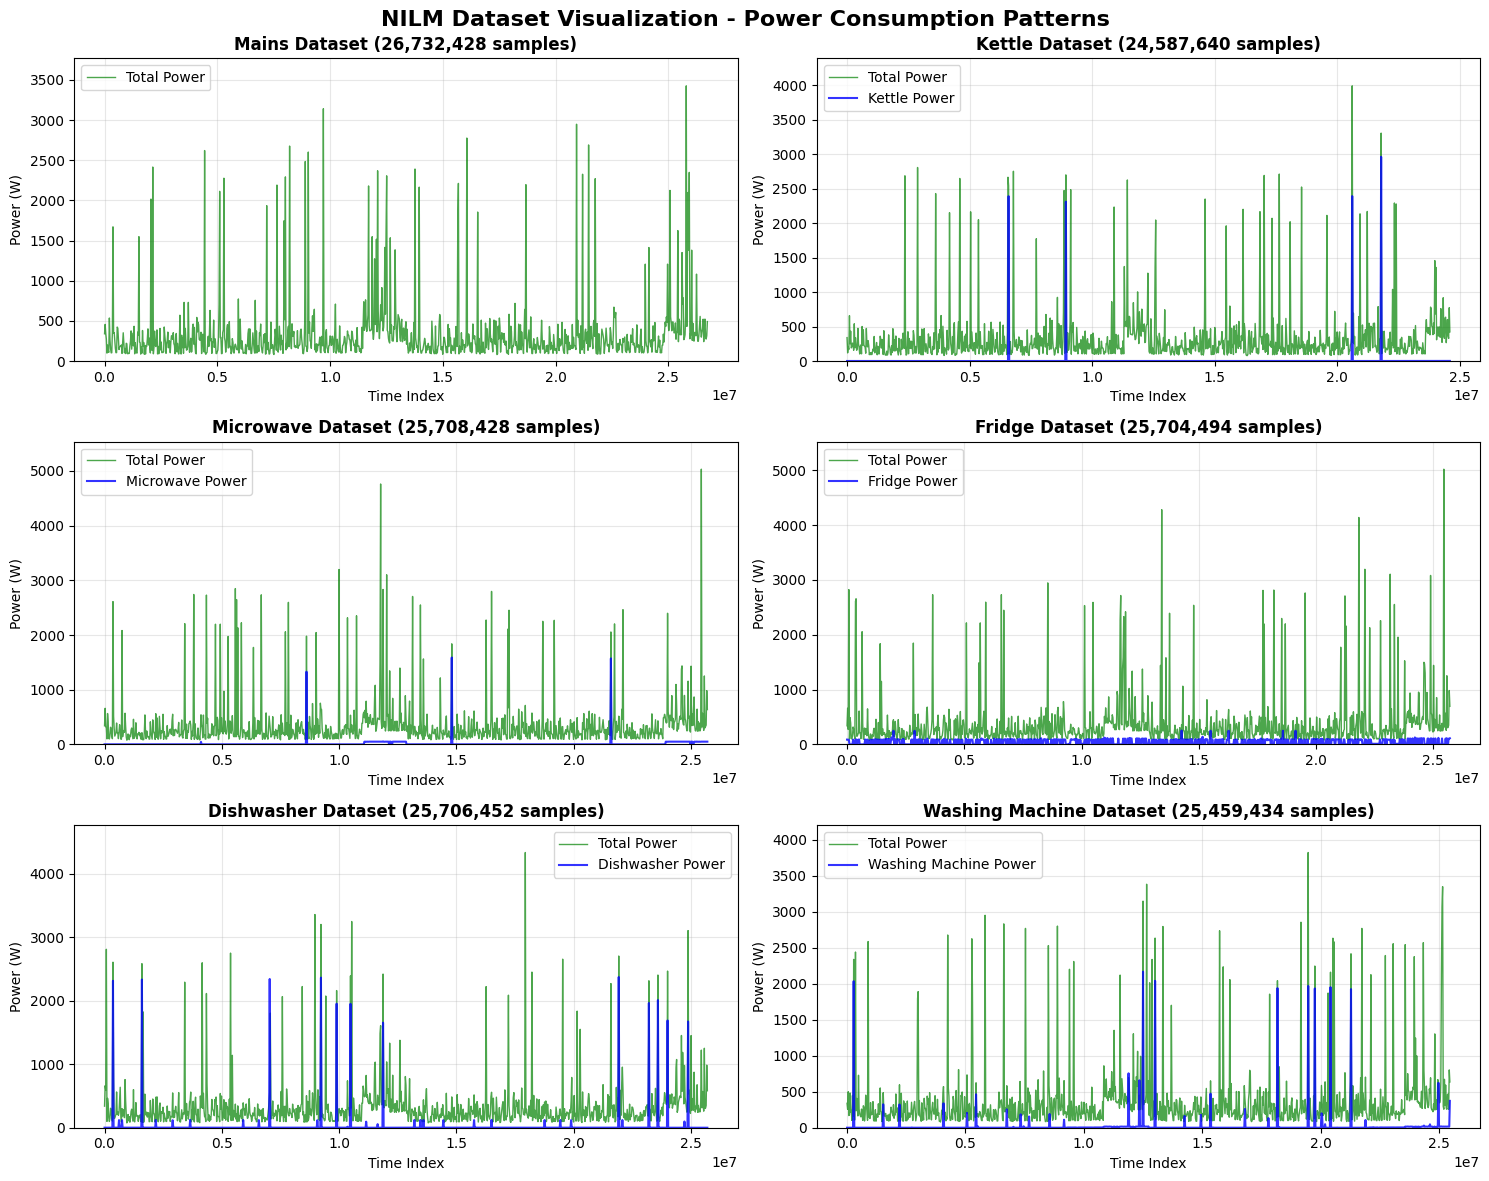


SUMMARY STATISTICS

Mains Dataset:
  Total samples: 26,732,428
  Mains power - Mean: 351.7W, Max: 8399.2W
  No appliance data available

Kettle Dataset:
  Total samples: 24,587,640
  Mains power - Mean: 338.1W, Max: 8253.7W
  Kettle power - Mean: 17.1W, Max: 3998.0W
  Usage ratio: 98.7%

Microwave Dataset:
  Total samples: 25,708,428
  Mains power - Mean: 352.5W, Max: 8399.2W
  Microwave power - Mean: 14.1W, Max: 3267.0W
  Usage ratio: 86.0%

Fridge Dataset:
  Total samples: 25,704,494
  Mains power - Mean: 352.5W, Max: 8399.2W
  Fridge power - Mean: 41.3W, Max: 3323.0W
  Usage ratio: 49.2%

Dishwasher Dataset:
  Total samples: 25,706,452
  Mains power - Mean: 352.5W, Max: 8399.2W
  Dishwasher power - Mean: 19.2W, Max: 3964.0W
  Usage ratio: 73.1%

Washing Machine Dataset:
  Total samples: 25,459,434
  Mains power - Mean: 354.5W, Max: 8399.2W
  Washing Machine power - Mean: 28.5W, Max: 3999.0W
  Usage ratio: 29.1%


In [12]:
# Visualize all datasets
print("="*60)
print("DATASET VISUALIZATION")
print("="*60)

import matplotlib.pyplot as plt
import numpy as np

# Check which datasets are available
datasets = {
    'Mains': 'entire_data_mains' if 'entire_data_mains' in locals() else None,
    'Kettle': 'entire_data_kettle' if 'entire_data_kettle' in locals() else None,
    'Microwave': 'entire_data_microwave' if 'entire_data_microwave' in locals() else None,
    'Fridge': 'entire_data_fridge' if 'entire_data_fridge' in locals() else None,
    'Dishwasher': 'entire_data_dishwasher' if 'entire_data_dishwasher' in locals() else None,
    'Washing Machine': 'entire_data_washing_machine' if 'entire_data_washing_machine' in locals() else None
}

# Print dataset information
print("Dataset Information:")
for name, var_name in datasets.items():
    if var_name and var_name in locals():
        data = locals()[var_name]
        print(f"✅ {name}: {data.shape} samples")
        print(f"   Columns: {list(data.columns)}")
        
        # Check if there's an appliance column (not just P_mains)
        appliance_cols = [col for col in data.columns if col != 'P_mains']
        if appliance_cols:
            appliance_col = appliance_cols[0]
            print(f"   Mains power range: {data['P_mains'].min():.1f}W to {data['P_mains'].max():.1f}W")
            print(f"   {name} power range: {data[appliance_col].min():.1f}W to {data[appliance_col].max():.1f}W")
        else:
            print(f"   Power range: {data['P_mains'].min():.1f}W to {data['P_mains'].max():.1f}W")
        
        print(f"   NaN values: {data.isnull().sum().sum()}")
        print()
    else:
        print(f"❌ {name}: Not available")
        print()

# Create visualization plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('NILM Dataset Visualization - Power Consumption Patterns', fontsize=16, fontweight='bold')

plot_idx = 0
for name, var_name in datasets.items():
    if var_name and var_name in locals() and plot_idx < 6:
        data = locals()[var_name]
        row = plot_idx // 2
        col = plot_idx % 2
        
        # Sample data for visualization (max 1000 points)
        if len(data) > 1000:
            step = len(data) // 1000
            plot_data = data.iloc[::step]
        else:
            plot_data = data
        
        # Plot mains power
        axes[row, col].plot(plot_data.index, plot_data['P_mains'], 'g-', label='Total Power', linewidth=1, alpha=0.7)
        
        # Plot appliance power if available
        appliance_cols = [col for col in data.columns if col != 'P_mains']
        if appliance_cols:
            appliance_col = appliance_cols[0]
            axes[row, col].plot(plot_data.index, plot_data[appliance_col], 'b-', label=f'{name} Power', linewidth=1.5, alpha=0.8)
            max_power = max(plot_data['P_mains'].max(), plot_data[appliance_col].max())
        else:
            max_power = plot_data['P_mains'].max()
        
        axes[row, col].set_title(f'{name} Dataset ({len(data):,} samples)', fontsize=12, fontweight='bold')
        axes[row, col].set_xlabel('Time Index')
        axes[row, col].set_ylabel('Power (W)')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
        
        # Set y-axis to start from 0
        axes[row, col].set_ylim(0, max_power * 1.1)
        
        plot_idx += 1

# Hide empty subplots
for i in range(plot_idx, 6):
    row = i // 2
    col = i % 2
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

for name, var_name in datasets.items():
    if var_name and var_name in locals():
        data = locals()[var_name]
        appliance_cols = [col for col in data.columns if col != 'P_mains']
        
        print(f"\n{name} Dataset:")
        print(f"  Total samples: {len(data):,}")
        print(f"  Mains power - Mean: {data['P_mains'].mean():.1f}W, Max: {data['P_mains'].max():.1f}W")
        
        if appliance_cols:
            appliance_col = appliance_cols[0]
            print(f"  {name} power - Mean: {data[appliance_col].mean():.1f}W, Max: {data[appliance_col].max():.1f}W")
            print(f"  Usage ratio: {(data[appliance_col] > 0).sum() / len(data) * 100:.1f}%")
        else:
            print(f"  No appliance data available")


In [13]:
print(entire_data_mains)
print(entire_data_kettle)
print(entire_data_microwave)
print(entire_data_fridge)
print(entire_data_dishwasher)
print(entire_data_washing_machine)

print("*********************************************************************") 

print("NaN | Length Count:")
print(f"Mains: {entire_data_mains.isnull().sum().sum()} | {len(entire_data_mains)}")
print(f"Kettle: {entire_data_kettle.isnull().sum().sum()} | {len(entire_data_kettle)}")
print(f"Microwave: {entire_data_microwave.isnull().sum().sum()} | {len(entire_data_microwave)}")
print(f"Fridge: {entire_data_fridge.isnull().sum().sum()} | {len(entire_data_fridge)}")
print(f"Dishwasher: {entire_data_dishwasher.isnull().sum().sum()} | {len(entire_data_dishwasher)}")
print(f"Washing Machine: {entire_data_washing_machine.isnull().sum().sum()} | {len(entire_data_washing_machine)}")

    

             P_mains
0         339.523987
1         339.588348
2         339.195007
3         339.511688
4         339.971649
...              ...
26732423  596.021667
26732424  598.163330
26732425  604.718323
26732426  600.098328
26732427  596.934998

[26732428 rows x 1 columns]
             P_mains  kettle
0         339.523987     1.0
1         339.588348     1.0
2         339.195007     1.0
3         339.511688     1.0
4         339.971649     1.0
...              ...     ...
24587635  369.751678     2.0
24587636  378.301666     2.0
24587637  369.864990     2.0
24587638  373.083344     2.0
24587639  384.841675     2.0

[24587640 rows x 2 columns]
             P_mains  microwave
0         339.523987        1.0
1         339.588348        1.0
2         339.195007        1.0
3         339.511688        1.0
4         339.971649        1.0
...              ...        ...
25708423  603.614990       48.0
25708424  620.674988       48.0
25708425  639.799988       48.0
25708426  656.754944  

In [18]:
#****************************************************************************
#                                Normalize the data
#****************************************************************************
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

print("="*60)
print("STEP 4: NORMALIZATION PER DATASET (Z-score)")
print("="*60)

# Collect available datasets
dataset_objs = {
    'mains': locals().get('entire_data_mains', None),
    'kettle': locals().get('entire_data_kettle', None),
    'microwave': locals().get('entire_data_microwave', None),
    'fridge': locals().get('entire_data_fridge', None),
    'dishwasher': locals().get('entire_data_dishwasher', None),
    'washing_machine': locals().get('entire_data_washing_machine', None),
}

# Dictionary to store normalization parameters (mean and std)
normalization_params = {}

for name, df in dataset_objs.items():
    if df is None:
        print(f"❌ Skipping {name}: dataset not found")
        continue
    if not isinstance(df, pd.DataFrame) or df.empty:
        print(f"❌ Skipping {name}: not a valid non-empty DataFrame")
        continue

    print(f"\nProcessing {name} dataset...")
    print(f"Data shape: {df.shape}")
    print(f"Original data stats:")
    print(df.describe())

    # Convert to numpy array for normalization
    X = df.values  # Shape: (samples, features)

    # Z-score normalization (mean=0, std=1)
    scaler_z = StandardScaler()
    X_norm_z = scaler_z.fit_transform(X)

    # Convert back to DataFrame
    df_norm = pd.DataFrame(X_norm_z, 
                           index=df.index, 
                           columns=df.columns)

    print(f"\nZ-score normalized data stats:")
    print(df_norm.describe())

    # Save normalization parameters for later use
    normalization_params[name] = {
        'mean': scaler_z.mean_,
        'std': scaler_z.scale_
    }

    print(f"\nNormalization parameters for {name}:")
    print(f"Mean: {normalization_params[name]['mean']}")
    print(f"Std: {normalization_params[name]['std']}")

    # Verify normalization worked
    print(f"\nVerification for {name}:")
    print(f"Normalized data mean: {df_norm.mean().mean():.6f} (should be ~0)")
    print(f"Normalized data std: {df_norm.std().mean():.6f} (should be ~1)")

    # Store normalized dataset in memory (no saving)
    var_norm_name = f"entire_data_{name}_norm"
    globals()[var_norm_name] = df_norm
    print(f"✅ {name}: Normalized and stored in memory")

print("\n" + "="*60)
print("NORMALIZATION COMPLETE - READY FOR NEXT STEP")
print("="*60)
print("✅ All datasets normalized and stored in memory")
print("✅ No .npy files saved - in-memory normalization only")
print("✅ Normalization parameters accessible via normalization_params['<dataset_name>']")


STEP 4: NORMALIZATION PER DATASET (Z-score)

Processing mains dataset...
Data shape: (26732428, 1)
Original data stats:
            P_mains
count  2.673243e+07
mean   3.517148e+02
std    4.688719e+02
min    0.000000e+00
25%    1.524933e+02
50%    2.313117e+02
75%    3.688850e+02
max    8.399210e+03

Z-score normalized data stats:
            P_mains
count  2.673243e+07
mean  -9.132751e-09
std    1.000000e+00
min   -7.501298e-01
25%   -4.248953e-01
50%   -2.567933e-01
75%    3.662023e-02
max    1.716353e+01

Normalization parameters for mains:
Mean: [351.71481575]
Std: [468.87190842]

Verification for mains:
Normalized data mean: -0.000000 (should be ~0)
Normalized data std: 1.000000 (should be ~1)
✅ mains: Normalized and stored in memory

Processing kettle dataset...
Data shape: (24587640, 2)
Original data stats:
            P_mains        kettle
count  2.458764e+07  2.458764e+07
mean   3.380890e+02  1.712358e+01
std    4.560867e+02  2.005956e+02
min    0.000000e+00  0.000000e+00
25%  

Create times windows

In [21]:
#****************************************************************************
#               Create sequences for each appliance using normalized data
#****************************************************************************
import numpy as np

chunk_size = 240
window_length = 480

print("="*60)
print("STEP 5: CREATE TIME WINDOWS FROM NORMALIZED DATA")
print("="*60)

# List of normalized datasets to process
normalized_datasets = {
    'mains': 'entire_data_mains_norm',
    'kettle': 'entire_data_kettle_norm',
    'microwave': 'entire_data_microwave_norm',
    'fridge': 'entire_data_fridge_norm',
    'dishwasher': 'entire_data_dishwasher_norm',
    'washing_machine': 'entire_data_washing_machine_norm'
}

# Dictionary to store generated sequences in memory
sequences_data = {}

for std_app, dataset_name in normalized_datasets.items():
    if dataset_name in locals():
        data = locals()[dataset_name]
        print(f"\nProcessing {std_app} sequences...")
        print(f"Dataset shape: {data.shape}")
        
        # Convert to numpy
        data_array = data.values
        
        # Create overlapping windows
        sequences = []
        for i in range(0, len(data_array) - window_length, chunk_size):
            window = data_array[i:i + window_length]
            sequences.append(window)
        
        if len(sequences) > 0:
            # Convert to 3D array
            sequences_3d = np.stack(sequences)
            print(f"✅ {std_app} sequences: {sequences_3d.shape}")
            print(f"   - Number of windows: {sequences_3d.shape[0]}")
            print(f"   - Window length: {sequences_3d.shape[1]}")
            print(f"   - Features per timestep: {sequences_3d.shape[2]}")
            
            # Store in memory instead of saving
            sequences_data[std_app] = sequences_3d
            print(f"   - Stored in memory as: sequences_data['{std_app}']")
        else:
            print(f"❌ {std_app}: Not enough data for windowing (need {window_length} samples)")
    else:
        print(f"❌ {std_app}: Dataset {dataset_name} not found")

print("\n" + "="*60)
print("SEQUENCE CREATION COMPLETE - READY FOR NEXT STEP")
print("="*60)
print("✅ All sequences stored in memory")
print("✅ Access them via: sequences_data['<appliance_name>']")
print("✅ No .npy files saved - data kept in RAM for next stage")


STEP 5: CREATE TIME WINDOWS FROM NORMALIZED DATA

Processing mains sequences...
Dataset shape: (26732428, 1)
✅ mains sequences: (111384, 480, 1)
   - Number of windows: 111384
   - Window length: 480
   - Features per timestep: 1
   - Stored in memory as: sequences_data['mains']

Processing kettle sequences...
Dataset shape: (24587640, 2)
✅ kettle sequences: (102447, 480, 2)
   - Number of windows: 102447
   - Window length: 480
   - Features per timestep: 2
   - Stored in memory as: sequences_data['kettle']

Processing microwave sequences...
Dataset shape: (25708428, 2)
✅ microwave sequences: (107117, 480, 2)
   - Number of windows: 107117
   - Window length: 480
   - Features per timestep: 2
   - Stored in memory as: sequences_data['microwave']

Processing fridge sequences...
Dataset shape: (25704494, 2)
✅ fridge sequences: (107101, 480, 2)
   - Number of windows: 107101
   - Window length: 480
   - Features per timestep: 2
   - Stored in memory as: sequences_data['fridge']

Processi

Resheffle Data

In [24]:
#****************************************************************************
#                        Shuffle sequences for each appliance
#****************************************************************************
import numpy as np

print("="*60)
print("STEP 6: SHUFFLE SEQUENCES (IN-MEMORY)")
print("="*60)

# Set random seed for reproducibility
np.random.seed(42)

# Ensure sequences_data exists
if 'sequences_data' not in locals():
    print("❌ sequences_data not found in memory. Please run Step 5 first.")
else:
    shuffled_sequences = {}

    for std_app in normalized_datasets.keys():
        if std_app in sequences_data:
            sequences = sequences_data[std_app]
            print(f"📊 {std_app}: {sequences.shape} sequences in memory")

            # Shuffle sequences
            np.random.shuffle(sequences)

            # Store shuffled sequences in a new dictionary
            shuffled_sequences[std_app] = sequences
            print(f"✅ {std_app}: Sequences shuffled and stored in memory")
        else:
            print(f"❌ {std_app}: No sequence data found in memory")

    print("\n" + "="*60)
    print("SHUFFLING COMPLETE - READY FOR NEXT STEP")
    print("="*60)
    print("✅ All sequences shuffled and stored in memory")
    print("✅ Access shuffled data via: shuffled_sequences['<appliance_name>']")
    print("✅ No files saved - in-memory workflow only")
    print("Random seed set to 42 for reproducibility.")


STEP 6: SHUFFLE SEQUENCES (IN-MEMORY)
📊 mains: (111384, 480, 1) sequences in memory
✅ mains: Sequences shuffled and stored in memory
📊 kettle: (102447, 480, 2) sequences in memory
✅ kettle: Sequences shuffled and stored in memory
📊 microwave: (107117, 480, 2) sequences in memory
✅ microwave: Sequences shuffled and stored in memory
📊 fridge: (107101, 480, 2) sequences in memory
✅ fridge: Sequences shuffled and stored in memory
📊 dishwasher: (107109, 480, 2) sequences in memory
✅ dishwasher: Sequences shuffled and stored in memory
📊 washing_machine: (106079, 480, 2) sequences in memory
✅ washing_machine: Sequences shuffled and stored in memory

SHUFFLING COMPLETE - READY FOR NEXT STEP
✅ All sequences shuffled and stored in memory
✅ Access shuffled data via: shuffled_sequences['<appliance_name>']
✅ No files saved - in-memory workflow only
Random seed set to 42 for reproducibility.


Split Dataset

In [29]:
#****************************************************************************
#             Split shuffled sequences into train / val / test sets
#****************************************************************************
import numpy as np

print("="*60)
print("STEP 7: SPLIT SEQUENCES INTO TRAIN/VAL/TEST")
print("="*60)

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

print(f"Split ratios: Train={train_ratio:.1%}, Val={val_ratio:.1%}, Test={test_ratio:.1%}")

# Ensure shuffled_sequences exist
if 'shuffled_sequences' not in locals():
    print("❌ shuffled_sequences not found in memory. Please run Step 6 first.")
else:
    for std_app in normalized_datasets.keys():
        try:
            # Get shuffled sequence data from memory
            if std_app not in shuffled_sequences:
                print(f"❌ {std_app}: No shuffled data found in memory")
                continue

            sequences = shuffled_sequences[std_app]
            print(f"\n📊 {std_app}: {sequences.shape} sequences loaded from memory")

            # Calculate split indices
            n_samples = len(sequences)
            train_end = int(n_samples * train_ratio)
            val_end = train_end + int(n_samples * val_ratio)

            # Split sequences
            train_set = sequences[:train_end]
            val_set = sequences[train_end:val_end]
            test_set = sequences[val_end:]

            # Save splits to .npy files
            np.save(f'train_{std_app}.npy', train_set)
            np.save(f'val_{std_app}.npy', val_set)
            np.save(f'test_{std_app}.npy', test_set)

            # Report split sizes
            print(f"✅ {std_app} splits:")
            print(f"   - Train: {train_set.shape[0]:,} sequences ({train_set.shape[0]/n_samples:.1%})")
            print(f"   - Val:   {val_set.shape[0]:,} sequences ({val_set.shape[0]/n_samples:.1%})")
            print(f"   - Test:  {test_set.shape[0]:,} sequences ({test_set.shape[0]/n_samples:.1%})")

        except Exception as e:
            print(f"❌ {std_app}: Error - {str(e)}")

    print("\n" + "="*60)
    print("SPLITTING COMPLETE")
    print("="*60)
    print("Saved files:")
    for std_app in normalized_datasets.keys():
        print(f"✅ train_{std_app}.npy")
        print(f"✅ val_{std_app}.npy")
        print(f"✅ test_{std_app}.npy")


STEP 7: SPLIT SEQUENCES INTO TRAIN/VAL/TEST
Split ratios: Train=80.0%, Val=10.0%, Test=10.0%

📊 mains: (111384, 480, 1) sequences loaded from memory
✅ mains splits:
   - Train: 89,107 sequences (80.0%)
   - Val:   11,138 sequences (10.0%)
   - Test:  11,139 sequences (10.0%)

📊 kettle: (102447, 480, 2) sequences loaded from memory
✅ kettle splits:
   - Train: 81,957 sequences (80.0%)
   - Val:   10,244 sequences (10.0%)
   - Test:  10,246 sequences (10.0%)

📊 microwave: (107117, 480, 2) sequences loaded from memory
✅ microwave splits:
   - Train: 85,693 sequences (80.0%)
   - Val:   10,711 sequences (10.0%)
   - Test:  10,713 sequences (10.0%)

📊 fridge: (107101, 480, 2) sequences loaded from memory
✅ fridge splits:
   - Train: 85,680 sequences (80.0%)
   - Val:   10,710 sequences (10.0%)
   - Test:  10,711 sequences (10.0%)

📊 dishwasher: (107109, 480, 2) sequences loaded from memory
✅ dishwasher splits:
   - Train: 85,687 sequences (80.0%)
   - Val:   10,710 sequences (10.0%)
   - Te